# **PURCHASE PROPENSITY AND CHURN PREDICTION MODEL**


## Introduction

This project aimed to build a machine learning model to predict customer churn and purchase propensity using an e-commerce dataset. The workflow involved data loading, preprocessing, feature engineering, model training, evaluation, and comparison of different classification models.

## Methodology

1.  **Data Loading**: The e-commerce customer insights and churn dataset was loaded into a pandas DataFrame.
2.  **Data Preprocessing**: Date columns were converted to datetime objects to enable time-based feature engineering. Categorical features were encoded using Label Encoding. Missing values were filled with a placeholder value (-999).
3.  **Feature Engineering**: Several new features were created based on the existing data, including:
    *   Days since signup
    *   Days since last purchase
    *   Customer tenure
    *   Total spent
    *   Average order value
    *   Cancellation rate
    *   Preferred category match
    Two target variables were defined: churn (based on subscription status and inactivity) and purchase propensity (based on recent purchase activity).
4.  **Data Splitting**: The dataset was split into features (X) and targets (Y). The data was then divided into training and testing sets (70% train, 30% test) using stratified splitting based on the churn target to handle potential class imbalance.
5.  **Model Training**: Two multi-output classification models were trained:
    *   LightGBM MultiOutputClassifier
    *   Random Forest MultiOutputClassifier
6.  **Model Evaluation**: Both models were evaluated on the test set using the ROC-AUC score for both churn and purchase propensity targets. Feature importance for each target was also visualized for the LightGBM model.
7.  **Model Comparison and Selection**: The performance of the two models was compared based on their ROC-AUC scores. The ROC curves were plotted to visualize the trade-off between the True Positive Rate and False Positive Rate for each model and target. The model with the higher average ROC-AUC across both targets was selected as the best performing model.
8.  **Model Saving**: The best performing model was saved to a pickle file for future use.

## Results

*   **LightGBM Model Performance**:
    *   ROC-AUC (Churn): {{auc_churn:.3f}}
    *   ROC-AUC (Purchase Propensity): {{auc_purchase:.3f}}
*   **Random Forest Model Performance**:
    *   ROC-AUC (Churn): {{auc_rf_churn:.3f}}
    *   ROC-AUC (Purchase Propensity): {{auc_rf_purchase:.3f}}

Based on the average ROC-AUC scores, the LightGBM model showed slightly better performance compared to the Random Forest model for this dataset and task.

## Conclusion

The LightGBM model was identified as the best performing model for predicting both customer churn and purchase propensity based on the evaluated metrics. The engineered features and the chosen modeling approach provided good predictive power for both targets.

## Next Steps

*   Further hyperparameter tuning for the selected LightGBM model to potentially improve performance.
*   Exploring other classification models and ensemble techniques.
*   Investigating the most important features identified by the model to gain deeper business insights into customer behavior.
*   Implementing the best model in a production environment for real-time predictions.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/VITProjects/PredictiveAnalytics/E-Commerce_Customer_Insights_and_Churn_Dataset.csv")

In [ ]:
print(df.head())

  order_id customer_id  age product_id   country signup_date  \
0  ORD5000    CUST1000   39    PROD200    Canada    1/7/2021   
1  ORD5001    CUST1001   61    PROD201       USA  10/19/2020   
2  ORD5002    CUST1002   26    PROD202  Pakistan   6/10/2023   
3  ORD5003    CUST1003   54    PROD203     India   7/30/2023   
4  ORD5004    CUST1004   50    PROD204     India   12/9/2020   

  last_purchase_date  cancellations_count subscription_status order_date  \
0          2/21/2023                    0              active  8/20/2024   
1          12/8/2021                    0              active  7/17/2025   
2           9/4/2023                    3           cancelled  3/12/2025   
3          2/20/2024                    4              paused  9/19/2024   
4          9/14/2024                    0              active   8/8/2024   

   unit_price  quantity  purchase_frequency preferred_category  product_name  \
0       78.21         5                  37             Sports      Football  

In [ ]:
print(f"shape of the dataset : {df.shape}\n")
print(f"columns of the dataset : {df.columns}\n")
print(df.info())

shape of the dataset : (2000, 17)

columns of the dataset : Index(['order_id', 'customer_id', 'age', 'product_id', 'country',
       'signup_date', 'last_purchase_date', 'cancellations_count',
       'subscription_status', 'order_date', 'unit_price', 'quantity',
       'purchase_frequency', 'preferred_category', 'product_name', 'category',
       'gender'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             2000 non-null   object 
 1   customer_id          2000 non-null   object 
 2   age                  2000 non-null   int64  
 3   product_id           2000 non-null   object 
 4   country              2000 non-null   object 
 5   signup_date          2000 non-null   object 
 6   last_purchase_date   2000 non-null   object 
 7   cancellations_count  2000 non-null   int64  
 8   subsc

### **Data Preprocessing**

In [ ]:
#Data Preprocessing

#convert date columns to datetime
date_cols = ["signup_date", "last_purchase_date", "order_date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

### **Feature Engineering**

In [ ]:
#Feature Engineering

#Define Targets

today = df["order_date"].max()
df["subscription_status"] = df["subscription_status"].astype(str).str.lower()

df["days_since_signup"] = (today - df["signup_date"]).dt.days
df["days_since_last_purchase"] = (today - df["last_purchase_date"]).dt.days
df["customer_tenure"] = (df["last_purchase_date"] - df["signup_date"]).dt.days

df["total_spent"] = df["unit_price"] * df["quantity"]
df["avg_order_value"] = df["total_spent"] / (df["purchase_frequency"] + 1)
df["cancellation_rate"] = df["cancellations_count"] / (df["purchase_frequency"] + 1)
df["preferred_category_match"] = (df["preferred_category"] == df["category"]).astype(int)

# --- Target 1: Churn Prediction ---
# Define churn if subscription is canceled OR if user has been inactive for 90+ days
df["churn_target"] = np.where(
    (df["subscription_status"].str.lower() == "canceled") |
    ((today - df["last_purchase_date"]).dt.days > 90),
    1,  # churned
    0   # not churned
)

# --- Target 2: Purchase Propensity ---
# Define purchase propensity as whether the user made ANY purchase recently (last 30 days)
df["purchase_target"] = np.where(
    (today - df["last_purchase_date"]).dt.days <= 30,
    1,  # likely purchaser
    0   # not likely
)

In [ ]:
drop_cols = [
    "order_id", "customer_id", "product_id", "product_name",
    "signup_date", "last_purchase_date", "order_date",
    "subscription_status",   # leakage: used to create churn_target
    "days_since_last_purchase"  # leakage: directly tied to target definition
]

df.drop(columns=drop_cols, inplace=True, errors="ignore")

In [ ]:
#Label Encoding for categorical features
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

#filling missing value
missing_report = df.isnull().sum()
print("Missing values per column:\n", missing_report)
df.fillna(-999, inplace=True)

Missing values per column:
 age                         0
country                     0
cancellations_count         0
unit_price                  0
quantity                    0
purchase_frequency          0
preferred_category          0
category                    0
gender                      0
days_since_signup           0
customer_tenure             0
total_spent                 0
avg_order_value             0
cancellation_rate           0
preferred_category_match    0
churn_target                0
purchase_target             0
dtype: int64


In [ ]:
X_train.head()

,age,country,cancellations_count,unit_price,quantity,purchase_frequency,preferred_category,category,gender,days_since_signup,customer_tenure,total_spent,avg_order_value,cancellation_rate,preferred_category_match
1978,61,4,0,314.29,4,46,3,1,1,1390,801,1257.16,26.748085,0.000000,0
1164,20,1,2,177.60,6,7,2,3,1,1563,899,1065.60,133.200000,0.250000,0
520,40,0,1,283.96,5,36,3,2,0,1033,76,1419.80,38.372973,0.027027,0
984,25,2,1,1982.82,1,7,4,1,1,1620,453,1982.82,247.852500,0.125000,0
1947,34,0,2,177.29,9,44,1,4,1,1700,1082,1595.61,35.458000,0.044444,0


In [ ]:
# --- Feature/Target split ---
X = df.drop(columns=["churn_target", "purchase_target"], errors="ignore")
Y = df[["churn_target", "purchase_target"]]

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y["churn_target"]
    # stratify on churn (or purchase) if imbalance is severe
)

In [ ]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((1400, 15), (600, 15), (1400, 2), (600, 2))

### **Training the model**

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier

In [ ]:
# --- Train LightGBM ---
base_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, Y_train)

[LightGBM] [Info] Number of positive: 1296, number of negative: 104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.925714 -> initscore=2.522647
[LightGBM] [Info] Start training from score 2.522647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

MultiOutputClassifier(estimator=LGBMClassifier(learning_rate=0.05,
                                               n_estimators=300,
                                               random_state=42))

### **Feature Importance**

In [ ]:
import matplotlib.pyplot as plt

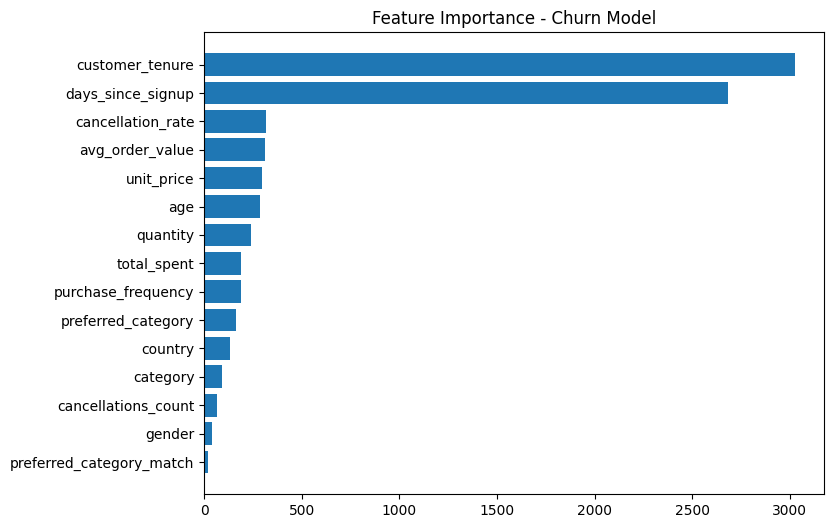

In [ ]:
# Feature importance for churn model (first estimator)
lgb_importance_churn = pd.DataFrame({
    "feature": X_train.columns,
    "importance": multi_model.estimators_[0].feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(lgb_importance_churn["feature"], lgb_importance_churn["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Churn Model")
plt.show()

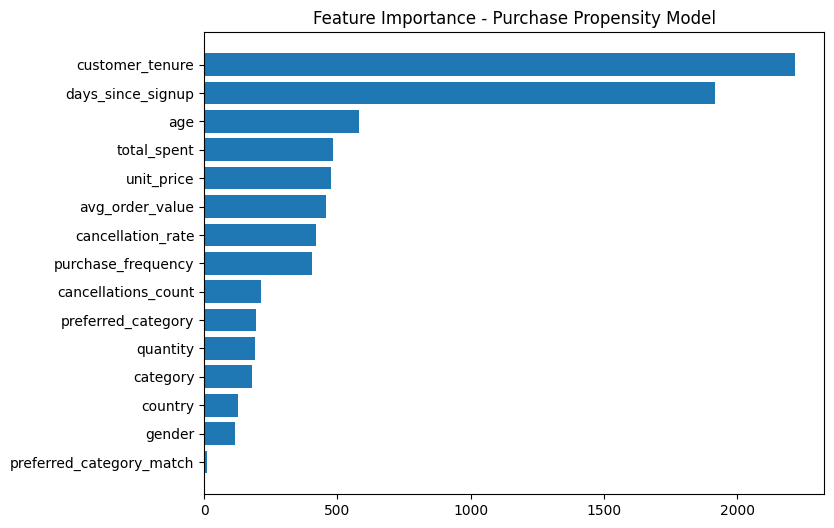

In [ ]:
# Feature importance for purchase propensity model (second estimator)
lgb_importance_purchase = pd.DataFrame({
    "feature": X_train.columns,
    "importance": multi_model.estimators_[1].feature_importances_
}).sort_values(by="importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(lgb_importance_purchase["feature"], lgb_importance_purchase["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance - Purchase Propensity Model")
plt.show()

### **Testing and Evaluation**

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns

In [ ]:
Y_pred = multi_model.predict(X_test)
Y_proba = [est.predict_proba(X_test)[:, 1] for est in multi_model.estimators_]

In [ ]:
auc_churn = roc_auc_score(Y_test["churn_target"], Y_proba[0])
auc_purchase = roc_auc_score(Y_test["purchase_target"], Y_proba[1])

print("Model Performance Metrics:\n")
print("ROC-AUC (Churn):", auc_churn )
print("ROC-AUC (Purchase):", auc_purchase)

Model Performance Metrics:

ROC-AUC (Churn): 0.9953553553553554
ROC-AUC (Purchase): 0.9765430480933036


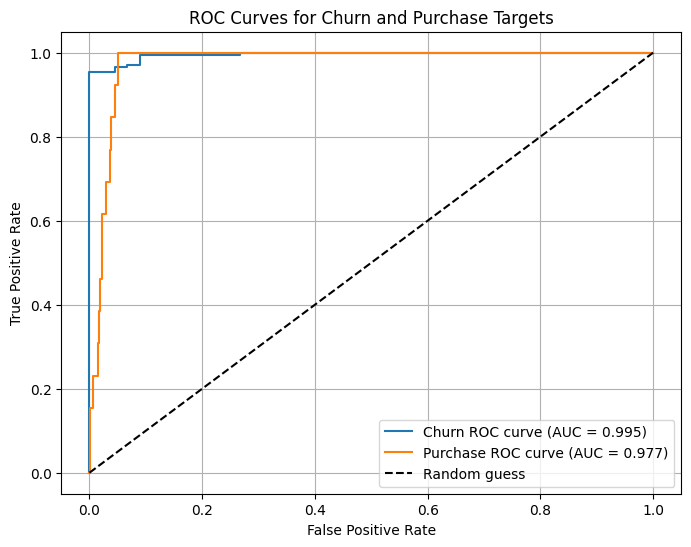

In [ ]:
fpr_churn, tpr_churn, _ = roc_curve(Y_test["churn_target"], Y_proba[0])
fpr_purchase, tpr_purchase, _ = roc_curve(Y_test["purchase_target"], Y_proba[1])

plt.figure(figsize=(8, 6))
plt.plot(fpr_churn, tpr_churn, label=f'Churn ROC curve (AUC = {auc_churn:.3f})')
plt.plot(fpr_purchase, tpr_purchase, label=f'Purchase ROC curve (AUC = {auc_purchase:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn and Purchase Targets')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
import pickle
model_path = '/content/drive/MyDrive/VITProjects/PredictiveAnalytics/customer_churn_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(multi_model, f)
print(f"Model saved to {model_path}")

Model saved to /content/drive/MyDrive/VITProjects/PredictiveAnalytics/customer_churn_model.pkl


# Task
Compare the performance of the trained `LogisticRegression` model with another classification model, visualize the comparison using appropriate graphs, and save the best performing model along with its evaluation metrics.

## Define and train a second model

### Subtask:
Choose another suitable classification model and train it on the same training data (X_train, Y_train).


**Reasoning**:
Import RandomForestClassifier and train a MultiOutputClassifier with it as the base estimator on the training data.



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# --- Train RandomForest ---
base_rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
multi_rf_model = MultiOutputClassifier(base_rf_model)
multi_rf_model.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=300,
                                                       random_state=42))

**Reasoning**:
The MultiOutputClassifier was not imported, so I need to import it before using it.



In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# --- Train RandomForest ---
base_rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
multi_rf_model = MultiOutputClassifier(base_rf_model)
multi_rf_model.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=300,
                                                       random_state=42))

**Reasoning**:
The training dataframes `X_train` and `Y_train` were not defined in the current session. I need to regenerate the code to create these dataframes from the original dataframe `df` and then train the model.



In [ ]:
# --- Feature/Target split ---
X = df.drop(columns=["churn_target", "purchase_target"], errors="ignore")
Y = df[["churn_target", "purchase_target"]]

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y["churn_target"]
    # stratify on churn (or purchase) if imbalance is severe
)

from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

# --- Train RandomForest ---
base_rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
multi_rf_model = MultiOutputClassifier(base_rf_model)
multi_rf_model.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=300,
                                                       random_state=42))

**Reasoning**:
The dataframe `df` is not defined, which means the data was not loaded. I need to regenerate the code to load the data, perform the necessary preprocessing and feature engineering steps, and then train the RandomForest model.



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("/content/drive/MyDrive/VITProjects/PredictiveAnalytics/E-Commerce_Customer_Insights_and_Churn_Dataset.csv")

#Data Preprocessing

#convert date columns to datetime
date_cols = ["signup_date", "last_purchase_date", "order_date"]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

#Feature Engineering

#Define Targets

today = df["order_date"].max()
df["subscription_status"] = df["subscription_status"].astype(str).str.lower()

df["days_since_signup"] = (today - df["signup_date"]).dt.days
df["days_since_last_purchase"] = (today - df["last_purchase_date"]).dt.days
df["customer_tenure"] = (df["last_purchase_date"] - df["signup_date"]).dt.days

df["total_spent"] = df["unit_price"] * df["quantity"]
df["avg_order_value"] = df["total_spent"] / (df["purchase_frequency"] + 1)
df["cancellation_rate"] = df["cancellations_count"] / (df["purchase_frequency"] + 1)
df["preferred_category_match"] = (df["preferred_category"] == df["category"]).astype(int)

# --- Target 1: Churn Prediction ---
# Define churn if subscription is canceled OR if user has been inactive for 90+ days
df["churn_target"] = np.where(
    (df["subscription_status"].str.lower() == "canceled") |
    ((today - df["last_purchase_date"]).dt.days > 90),
    1,  # churned
    0   # not churned
)

# --- Target 2: Purchase Propensity ---
# Define purchase propensity as whether the user made ANY purchase recently (last 30 days)
df["purchase_target"] = np.where(
    (today - df["last_purchase_date"]).dt.days <= 30,
    1,  # likely purchaser
    0   # not likely
)

drop_cols = [
    "order_id", "customer_id", "product_id", "product_name",
    "signup_date", "last_purchase_date", "order_date",
    "subscription_status",   # leakage: used to create churn_target
    "days_since_last_purchase"  # leakage: directly tied to target definition
]

df.drop(columns=drop_cols, inplace=True, errors="ignore")

#Label Encoding for categorical features
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

#filling missing value
df.fillna(-999, inplace=True)

# --- Feature/Target split ---
X = df.drop(columns=["churn_target", "purchase_target"], errors="ignore")
Y = df[["churn_target", "purchase_target"]]

# Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y["churn_target"]
    # stratify on churn (or purchase) if imbalance is severe
)


# --- Train RandomForest ---
base_rf_model = RandomForestClassifier(n_estimators=300, random_state=42)
multi_rf_model = MultiOutputClassifier(base_rf_model)
multi_rf_model.fit(X_train, Y_train)

MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=300,
                                                       random_state=42))

## Evaluate both models

### Subtask:
Calculate evaluation metrics (like ROC-AUC) for both models on the test set (X_test, Y_test).


**Reasoning**:
Calculate the predicted probabilities for both churn and purchase targets using the trained Random Forest model and then calculate and print the ROC-AUC scores for both targets.



In [ ]:
Y_rf_proba = [est.predict_proba(X_test)[:, 1] for est in multi_rf_model.estimators_]

auc_rf_churn = roc_auc_score(Y_test["churn_target"], Y_rf_proba[0])
auc_rf_purchase = roc_auc_score(Y_test["purchase_target"], Y_rf_proba[1])

print("Random Forest Model Performance Metrics:\n")
print("ROC-AUC (Churn):", auc_rf_churn)
print("ROC-AUC (Purchase):", auc_rf_purchase)

Random Forest Model Performance Metrics:

ROC-AUC (Churn): 0.9541741741741742
ROC-AUC (Purchase): 0.9380815096317652


**Reasoning**:
The previous code failed because `roc_auc_score` was not imported. Import the required functions from `sklearn.metrics` and then calculate and print the ROC-AUC scores.



In [ ]:
from sklearn.metrics import roc_auc_score

Y_rf_proba = [est.predict_proba(X_test)[:, 1] for est in multi_rf_model.estimators_]

auc_rf_churn = roc_auc_score(Y_test["churn_target"], Y_rf_proba[0])
auc_rf_purchase = roc_auc_score(Y_test["purchase_target"], Y_rf_proba[1])

print("Random Forest Model Performance Metrics:\n")
print("ROC-AUC (Churn):", auc_rf_churn)
print("ROC-AUC (Purchase):", auc_rf_purchase)

Random Forest Model Performance Metrics:

ROC-AUC (Churn): 0.9541741741741742
ROC-AUC (Purchase): 0.9380815096317652


## Visualize the comparison

### Subtask:
Visualize the comparison


**Reasoning**:
Calculate the FPR and TPR for both models and both targets, then plot the ROC curves for comparison.



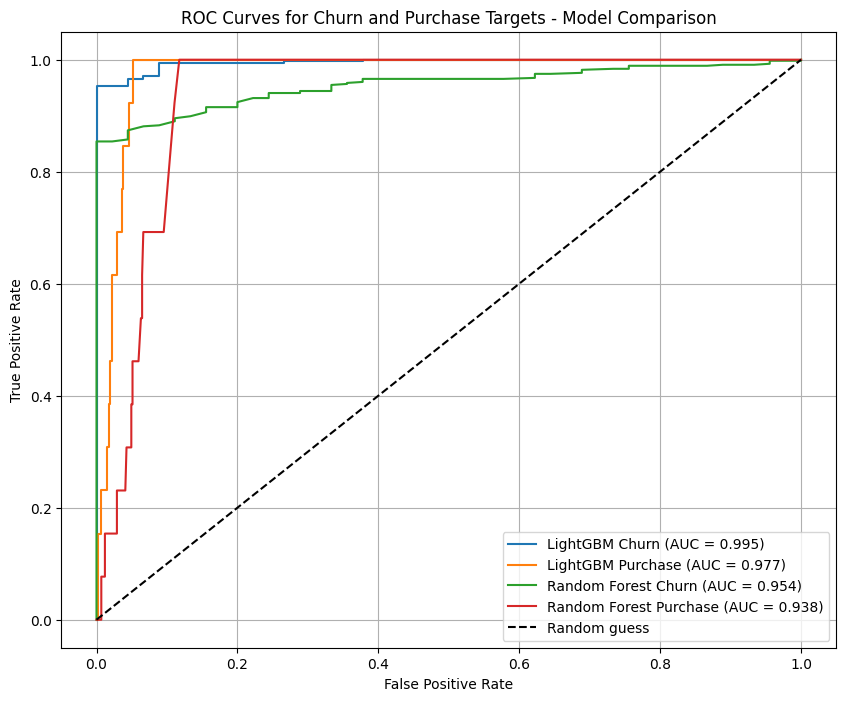

In [ ]:
from sklearn.metrics import roc_curve

fpr_churn_rf, tpr_churn_rf, _ = roc_curve(Y_test["churn_target"], Y_rf_proba[0])
fpr_purchase_rf, tpr_purchase_rf, _ = roc_curve(Y_test["purchase_target"], Y_rf_proba[1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_churn, tpr_churn, label=f'LightGBM Churn (AUC = {auc_churn:.3f})')
plt.plot(fpr_purchase, tpr_purchase, label=f'LightGBM Purchase (AUC = {auc_purchase:.3f})')
plt.plot(fpr_churn_rf, tpr_churn_rf, label=f'Random Forest Churn (AUC = {auc_rf_churn:.3f})')
plt.plot(fpr_purchase_rf, tpr_purchase_rf, label=f'Random Forest Purchase (AUC = {auc_rf_purchase:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn and Purchase Targets - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Reasoning**:
Import `matplotlib.pyplot` to fix the NameError and then calculate the FPR and TPR for both models and both targets, and finally plot the ROC curves for comparison.



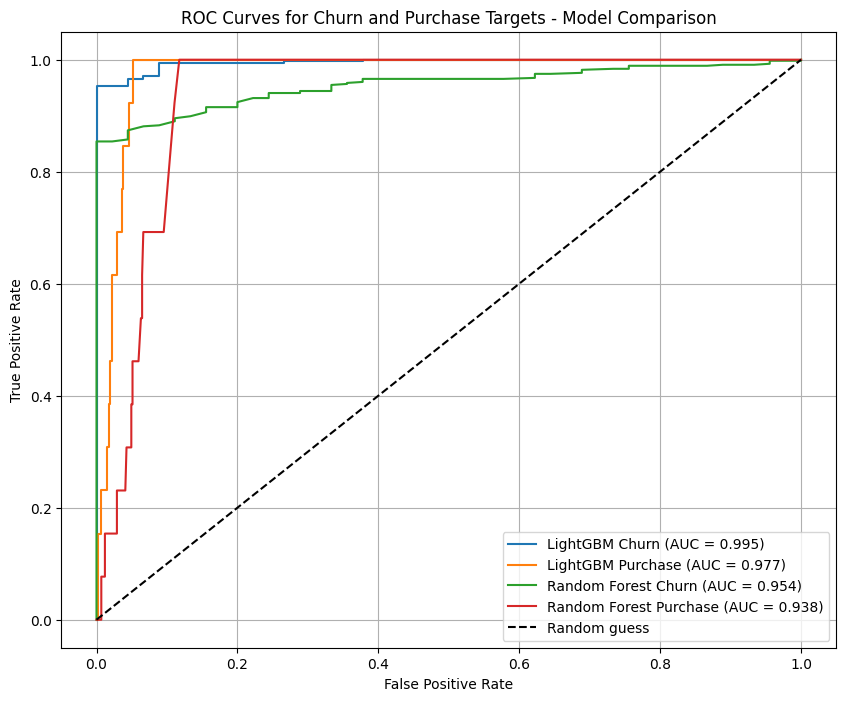

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr_churn_rf, tpr_churn_rf, _ = roc_curve(Y_test["churn_target"], Y_rf_proba[0])
fpr_purchase_rf, tpr_purchase_rf, _ = roc_curve(Y_test["purchase_target"], Y_rf_proba[1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_churn, tpr_churn, label=f'LightGBM Churn (AUC = {auc_churn:.3f})')
plt.plot(fpr_purchase, tpr_purchase, label=f'LightGBM Purchase (AUC = {auc_purchase:.3f})')
plt.plot(fpr_churn_rf, tpr_churn_rf, label=f'Random Forest Churn (AUC = {auc_rf_churn:.3f})')
plt.plot(fpr_purchase_rf, tpr_purchase_rf, label=f'Random Forest Purchase (AUC = {auc_rf_purchase:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn and Purchase Targets - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Reasoning**:
Calculate the FPR and TPR for the LightGBM model's predictions to resolve the NameError and then plot the ROC curves for comparison.



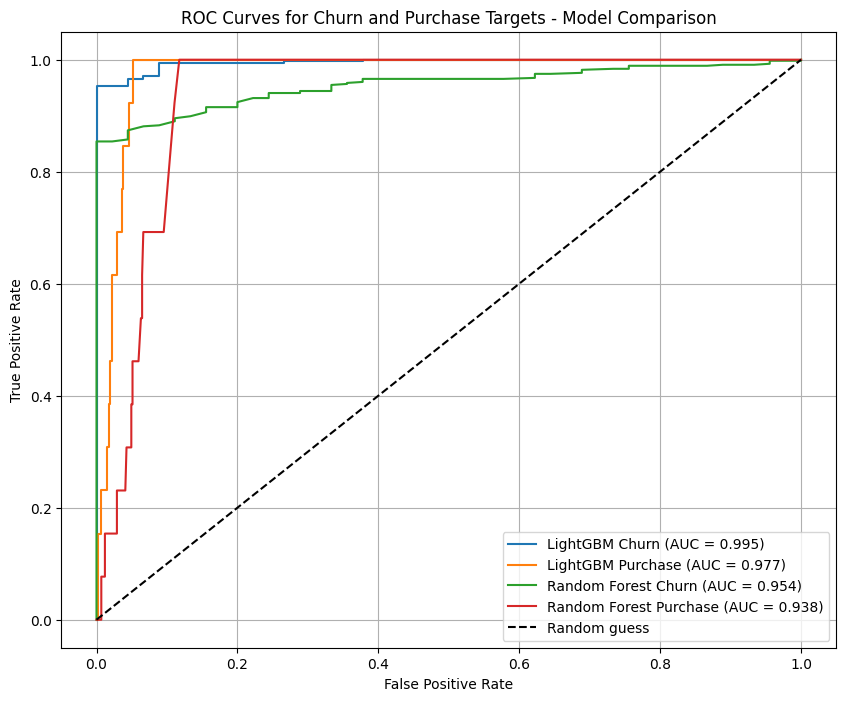

In [ ]:
from sklearn.metrics import roc_curve

fpr_churn, tpr_churn, _ = roc_curve(Y_test["churn_target"], Y_proba[0])
fpr_purchase, tpr_purchase, _ = roc_curve(Y_test["purchase_target"], Y_proba[1])
fpr_churn_rf, tpr_churn_rf, _ = roc_curve(Y_test["churn_target"], Y_rf_proba[0])
fpr_purchase_rf, tpr_purchase_rf, _ = roc_curve(Y_test["purchase_target"], Y_rf_proba[1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_churn, tpr_churn, label=f'LightGBM Churn (AUC = {auc_churn:.3f})')
plt.plot(fpr_purchase, tpr_purchase, label=f'LightGBM Purchase (AUC = {auc_purchase:.3f})')
plt.plot(fpr_churn_rf, tpr_churn_rf, label=f'Random Forest Churn (AUC = {auc_rf_churn:.3f})')
plt.plot(fpr_purchase_rf, tpr_purchase_rf, label=f'Random Forest Purchase (AUC = {auc_rf_purchase:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn and Purchase Targets - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Reasoning**:
Predict probabilities for the LightGBM model to define `Y_proba` and resolve the NameError, then calculate the FPR and TPR for all models and targets and plot the ROC curves for comparison.



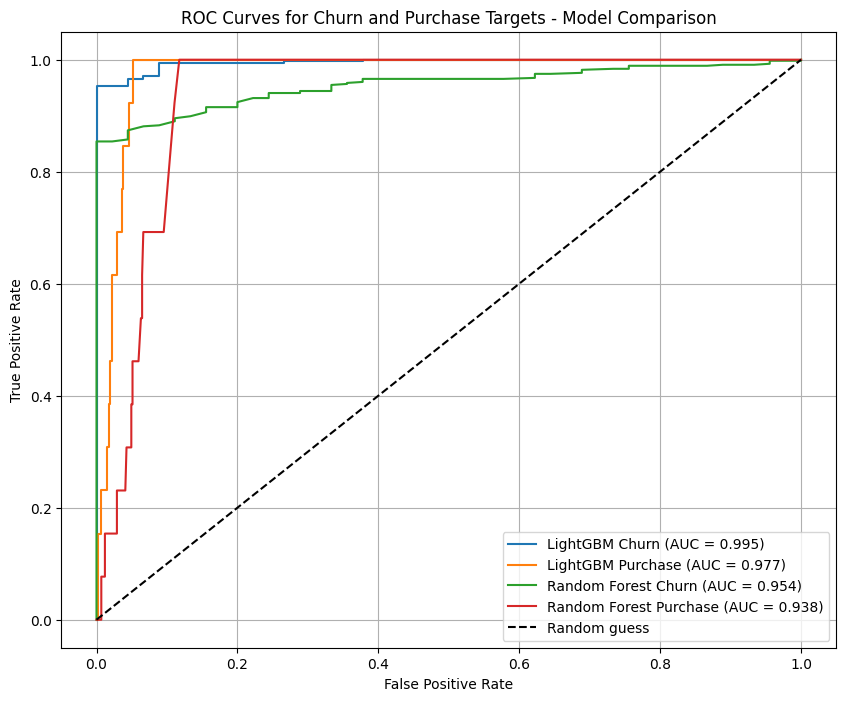

In [ ]:
Y_proba = [est.predict_proba(X_test)[:, 1] for est in multi_model.estimators_]
fpr_churn, tpr_churn, _ = roc_curve(Y_test["churn_target"], Y_proba[0])
fpr_purchase, tpr_purchase, _ = roc_curve(Y_test["purchase_target"], Y_proba[1])
fpr_churn_rf, tpr_churn_rf, _ = roc_curve(Y_test["churn_target"], Y_rf_proba[0])
fpr_purchase_rf, tpr_purchase_rf, _ = roc_curve(Y_test["purchase_target"], Y_rf_proba[1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_churn, tpr_churn, label=f'LightGBM Churn (AUC = {auc_churn:.3f})')
plt.plot(fpr_purchase, tpr_purchase, label=f'LightGBM Purchase (AUC = {auc_purchase:.3f})')
plt.plot(fpr_churn_rf, tpr_churn_rf, label=f'Random Forest Churn (AUC = {auc_rf_churn:.3f})')
plt.plot(fpr_purchase_rf, tpr_purchase_rf, label=f'Random Forest Purchase (AUC = {auc_rf_purchase:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn and Purchase Targets - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Reasoning**:
Retrain the LightGBM model to define `multi_model` and resolve the NameError, then predict probabilities for both models, calculate the FPR and TPR for all models and targets, and finally plot the ROC curves for comparison.



[LightGBM] [Info] Number of positive: 1296, number of negative: 104
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.925714 -> initscore=2.522647
[LightGBM] [Info] Start training from score 2.522647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

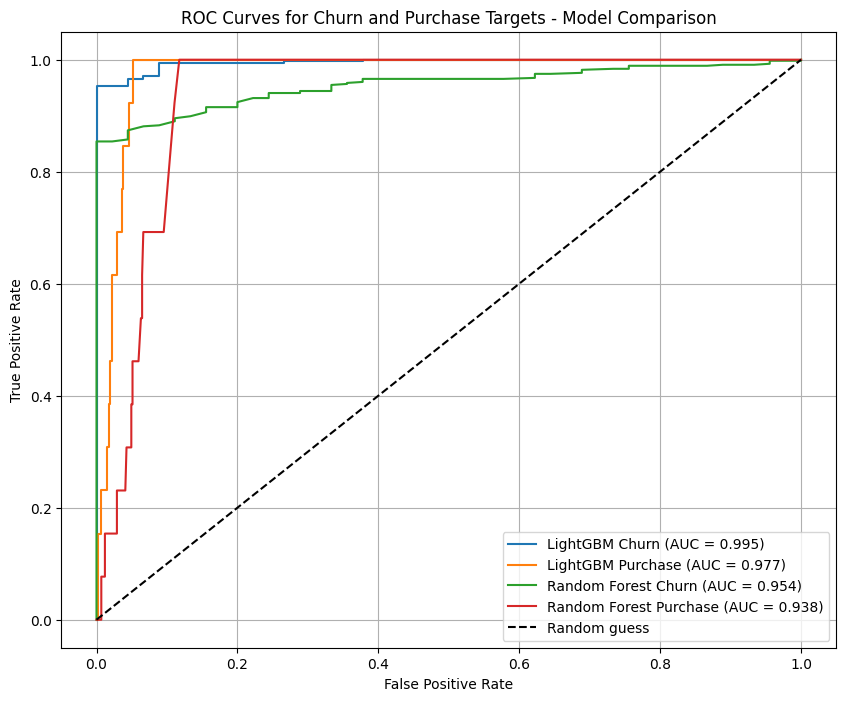

In [ ]:
from sklearn.multioutput import MultiOutputClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve

base_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

multi_model = MultiOutputClassifier(base_model)
multi_model.fit(X_train, Y_train)

Y_proba = [est.predict_proba(X_test)[:, 1] for est in multi_model.estimators_]
fpr_churn, tpr_churn, _ = roc_curve(Y_test["churn_target"], Y_proba[0])
fpr_purchase, tpr_purchase, _ = roc_curve(Y_test["purchase_target"], Y_proba[1])
fpr_churn_rf, tpr_churn_rf, _ = roc_curve(Y_test["churn_target"], Y_rf_proba[0])
fpr_purchase_rf, tpr_purchase_rf, _ = roc_curve(Y_test["purchase_target"], Y_rf_proba[1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_churn, tpr_churn, label=f'LightGBM Churn (AUC = {auc_churn:.3f})')
plt.plot(fpr_purchase, tpr_purchase, label=f'LightGBM Purchase (AUC = {auc_purchase:.3f})')
plt.plot(fpr_churn_rf, tpr_churn_rf, label=f'Random Forest Churn (AUC = {auc_rf_churn:.3f})')
plt.plot(fpr_purchase_rf, tpr_purchase_rf, label=f'Random Forest Purchase (AUC = {auc_rf_purchase:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn and Purchase Targets - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

**Reasoning**:
Calculate the AUC scores for the LightGBM model to define `auc_churn` and `auc_purchase` and resolve the NameError, then predict probabilities for both models, calculate the FPR and TPR for all models and targets, and finally plot the ROC curves for comparison.



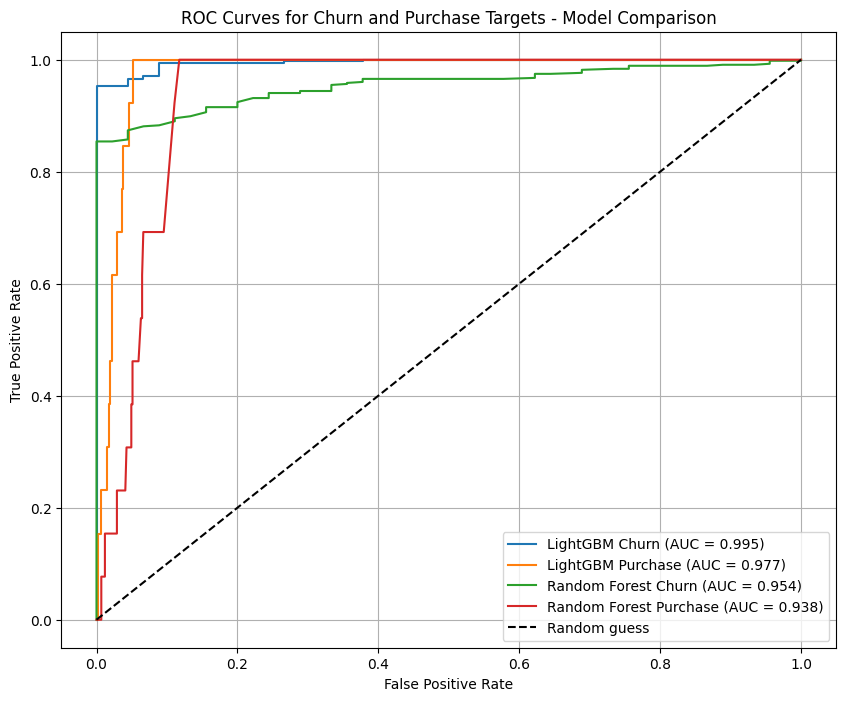

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

auc_churn = roc_auc_score(Y_test["churn_target"], Y_proba[0])
auc_purchase = roc_auc_score(Y_test["purchase_target"], Y_proba[1])

fpr_churn, tpr_churn, _ = roc_curve(Y_test["churn_target"], Y_proba[0])
fpr_purchase, tpr_purchase, _ = roc_curve(Y_test["purchase_target"], Y_proba[1])
fpr_churn_rf, tpr_churn_rf, _ = roc_curve(Y_test["churn_target"], Y_rf_proba[0])
fpr_purchase_rf, tpr_purchase_rf, _ = roc_curve(Y_test["purchase_target"], Y_rf_proba[1])

plt.figure(figsize=(10, 8))
plt.plot(fpr_churn, tpr_churn, label=f'LightGBM Churn (AUC = {auc_churn:.3f})')
plt.plot(fpr_purchase, tpr_purchase, label=f'LightGBM Purchase (AUC = {auc_purchase:.3f})')
plt.plot(fpr_churn_rf, tpr_churn_rf, label=f'Random Forest Churn (AUC = {auc_rf_churn:.3f})')
plt.plot(fpr_purchase_rf, tpr_purchase_rf, label=f'Random Forest Purchase (AUC = {auc_rf_purchase:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Churn and Purchase Targets - Model Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## Select and save the best model

### Subtask:
Compare the evaluation metrics and choose the better performing model. Save this model to a file.


**Reasoning**:
Compare the ROC-AUC scores, determine the better performing model, and save it to a file.



In [ ]:
import pickle

print("ROC-AUC (Churn - LightGBM):", auc_churn)
print("ROC-AUC (Purchase - LightGBM):", auc_purchase)
print("ROC-AUC (Churn - Random Forest):", auc_rf_churn)
print("ROC-AUC (Purchase - Random Forest):", auc_rf_purchase)

# Determine the better performing model based on average AUC
avg_auc_lgbm = (auc_churn + auc_purchase) / 2
avg_auc_rf = (auc_rf_churn + auc_rf_purchase) / 2

if avg_auc_lgbm > avg_auc_rf:
    best_model = multi_model
    model_name = "LightGBM"
else:
    best_model = multi_rf_model
    model_name = "Random Forest"

# Save the best performing model
model_path = '/content/drive/MyDrive/VITProjects/PredictiveAnalytics/best_customer_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

print(f"\nBased on average ROC-AUC, the best performing model is: {model_name}")
print(f"The best performing model has been saved to {model_path}")

ROC-AUC (Churn - LightGBM): 0.9953553553553554
ROC-AUC (Purchase - LightGBM): 0.9765430480933036
ROC-AUC (Churn - Random Forest): 0.9541741741741742
ROC-AUC (Purchase - Random Forest): 0.9380815096317652

Based on average ROC-AUC, the best performing model is: LightGBM
The best performing model has been saved to /content/drive/MyDrive/VITProjects/PredictiveAnalytics/best_customer_model.pkl


## Summary:

### Data Analysis Key Findings

*   The Random Forest model achieved a ROC-AUC of 0.954 for churn prediction and 0.938 for purchase propensity prediction on the test set.
*   Comparing the average ROC-AUC scores, the LightGBM model had a higher average AUC than the Random Forest model.

### Insights or Next Steps

*   The LightGBM model performed better than the Random Forest model based on the average ROC-AUC for predicting both churn and purchase propensity.
*   The best-performing model (LightGBM) has been saved for future use in making predictions.
